In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from fast_pagerank import pagerank
from fast_pagerank import pagerank_power
from scipy import sparse
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity
from sklearn.cluster import SpectralClustering

import utils

In [2]:
# Load data
df_data = pd.read_csv('../data/ice-cat-office-products.csv.gz', dtype=str, index_col=0)

# Filter out small product categories
# top_categories = utils.find_top_n_categories(df_data, top_n=3)
top_categories = [
     'Folders',                         # N=645
#     'Self-Adhesive Labels',            # N=324
#     'Multimedia Carts & Stands',       # N=317
#     'Calculators',                     # N=305
#     'Writing Notebooks'                # N=300
     'Ring Binders',                    # N=298
#     'Printer Cabinets & Stands',       # N=252
#     'Whiteboards',                     # N=232
#     'Fax Machines',                    # N=210
#     'File Storage Boxes'               # N=192
]
df_data = df_data[df_data.category_name.isin(top_categories)]

# Sort by category for later visualisation
df_data.sort_values('category_name', inplace=True)

product_features = utils.get_product_feature_columns_for_training(df_data)

In [3]:
df_play_data = df_data[['category_name'] + product_features].copy()

In [4]:
X_raw = utils.preprocess_dataframe(df_play_data)
X_raw.shape

(943, 160)

In [5]:
# Reduce to number of dimensions so the remaining dimensions
# explain at least 90 percent of the variance.
svd = PCA(n_components=0.9, random_state=42)
X_pca = svd.fit_transform(X_raw)
X_pca.shape

(943, 19)

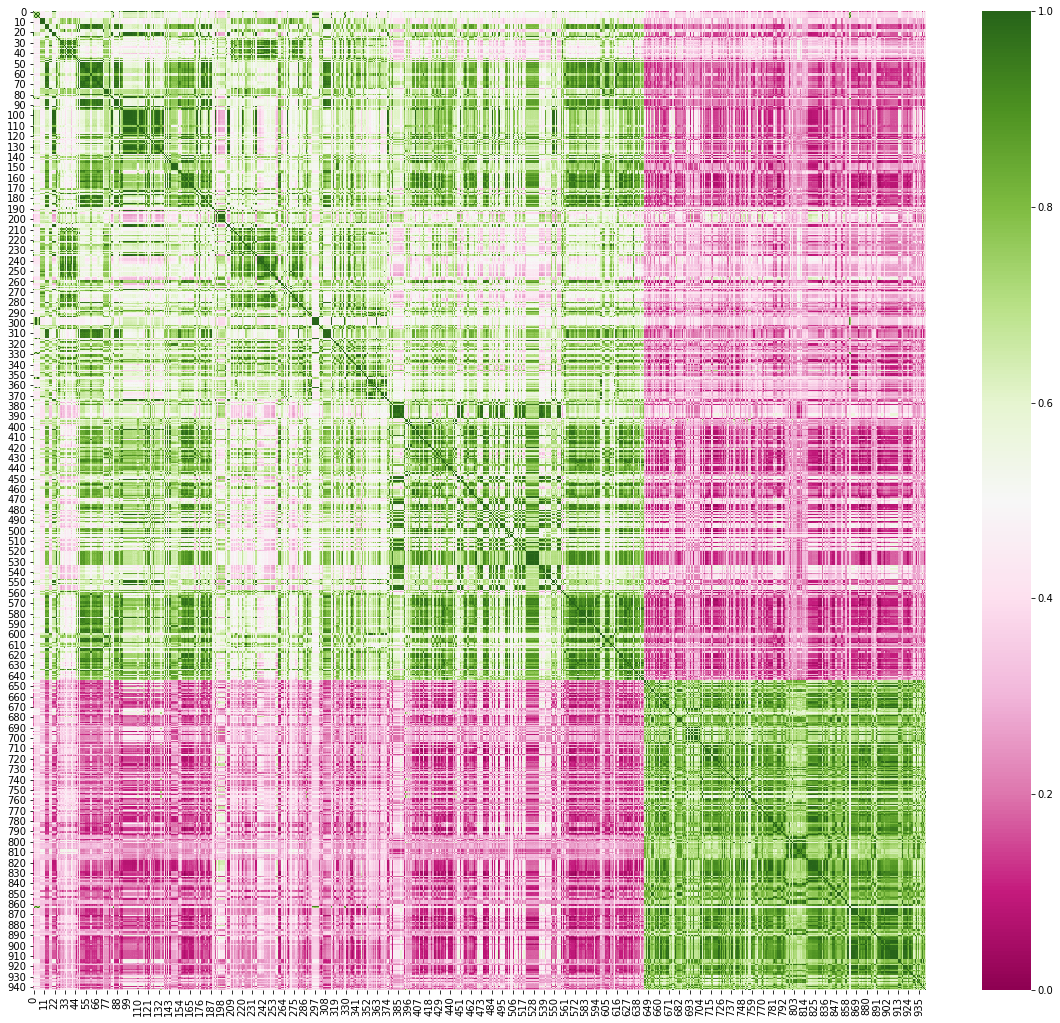

In [6]:
utils.plot_similarity_heatmap(X_pca, metric='cosine', normalise=True)

In [7]:
tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=300, random_state=3)
X_tsne = tsne.fit_transform(X_pca)

In [8]:
df_cleaned_data, features_by_type = utils.prepare_for_preprocessing(df_data)

# Add extra columns
df_cleaned_data['title'] = df_data['title']
df_cleaned_data['tsne_dim1'] = X_tsne[:,0]
df_cleaned_data['tsne_dim2'] = X_tsne[:,1]

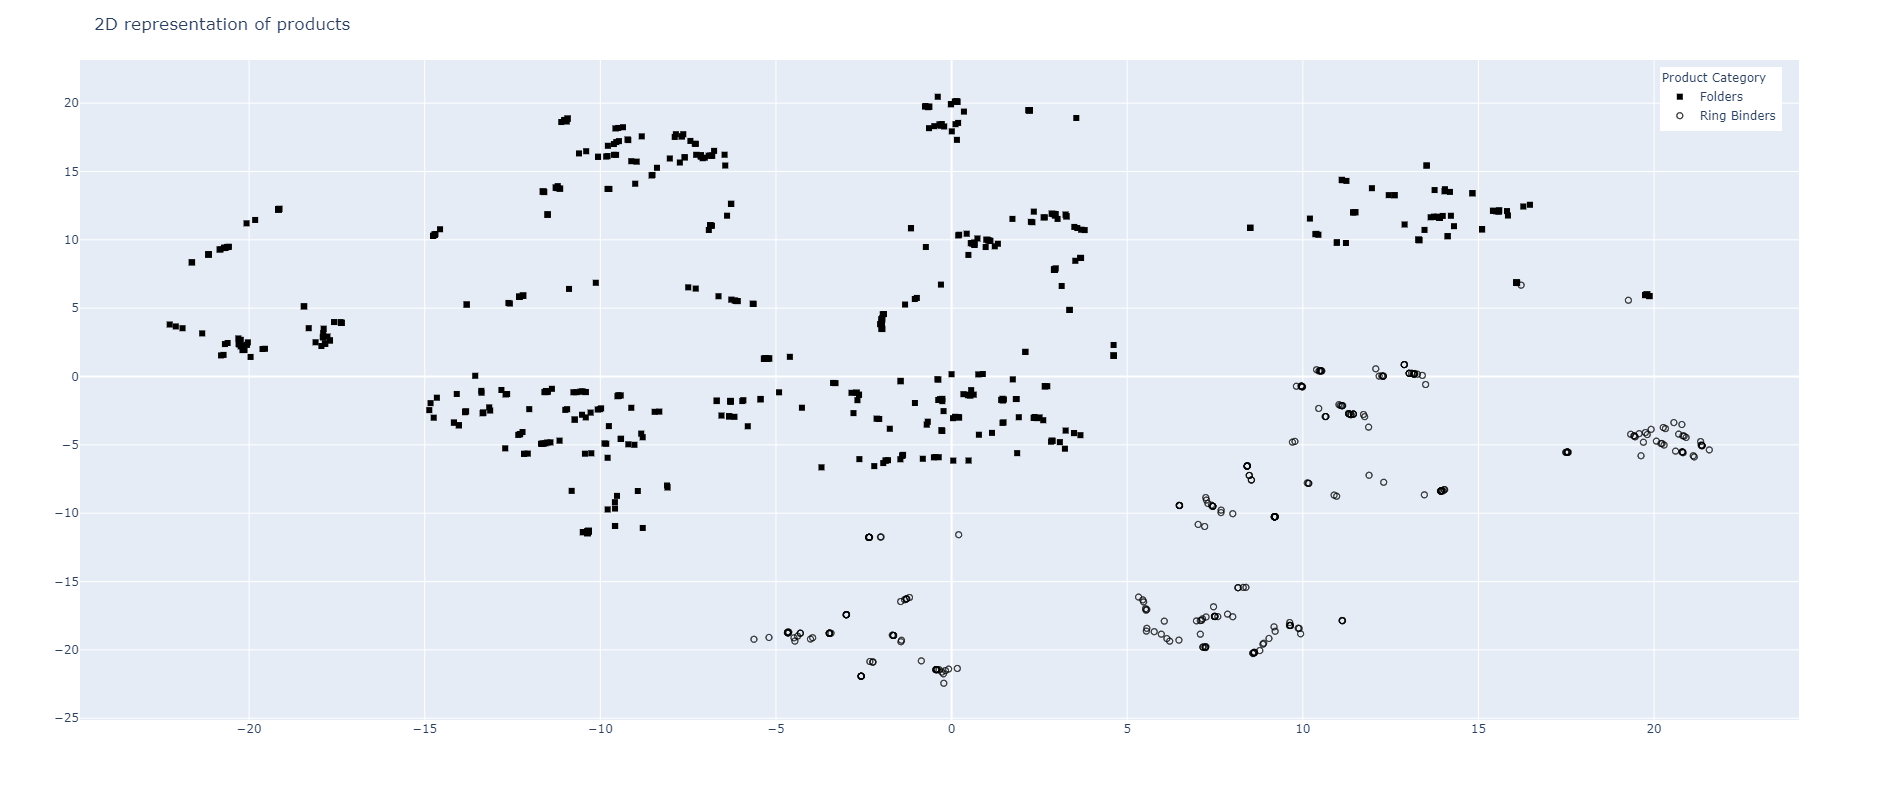

In [9]:
df_plot_data = df_cleaned_data.sort_values('category_name')

fig = px.scatter(
    df_plot_data,
    x="tsne_dim1",
    y="tsne_dim2",
    # color="category_name",
    color_discrete_sequence=['black', 'blue'],
    symbol = df_plot_data['category_name'],
    symbol_sequence= ['square', 'circle-open'],
    hover_name="title",
    hover_data={
        "category_name": False, "tsne_dim1": False, "tsne_dim2": False,
        # "Supplier": df_plot_data['supplier_name'],
        "Format": True,
        "Weight": True,
        "Orientation": True,
    },
)
fig.update_layout(
    legend=dict(
        title="Product Category",
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    ),
    title='2D representation of products',
    autosize=False,
    width=1200,
    height=800,
)
fig.update_xaxes(showticklabels=True, title="")
fig.update_yaxes(showticklabels=True, title="")
fig.show()

In [10]:
# Compute similarity matrix
similarity_matrix = cosine_similarity(X_pca)

# Normalise entries in the interval [0, 1]
similarity_matrix = (similarity_matrix - np.min(similarity_matrix)) / np.ptp(similarity_matrix)

# Perform clustering using similarity matrix
sc = SpectralClustering(n_clusters=20, affinity='precomputed', random_state=42)
sc.fit(similarity_matrix)

# Assign clusters to the original data
df_cleaned_data['cluster'] = sc.labels_
df_cleaned_data['cluster'] = df_cleaned_data['cluster'].astype(str)

In [11]:
# Count number of rows where clustering and known ground truths differ/agree
utils.group_clusters_per_category(df_cleaned_data)

cluster category_name  n_rows
0        0       Folders      63
1        1  Ring Binders      71
2       10  Ring Binders      63
3       11       Folders       4
5       12  Ring Binders      60
4       12       Folders       1
6       13       Folders      67
7       13  Ring Binders       5
8       14       Folders      49
10      15  Ring Binders      13
9       15       Folders       4
11      16  Ring Binders      37
12      17       Folders      48
13      18       Folders      65
14      19       Folders      32
15      19  Ring Binders       1
16       2       Folders     100
17       3       Folders       8
19       4  Ring Binders      46
18       4       Folders      12
20       5       Folders      13
21       5  Ring Binders       1
22       6       Folders      27
23       7       Folders      11
24       8       Folders       6
25       8  Ring Binders       1
26       9       Folders     135

In [12]:
# Combine clusters that agree with the ground truths (given product categories)
df_cleaned_data = utils.combined_similar_clusters(df_cleaned_data)

In [13]:
utils.group_clusters_per_category(df_cleaned_data)

cluster category_name  n_rows
1       12  Ring Binders      60
0       12       Folders       1
2       13       Folders      67
3       13  Ring Binders       5
5       15  Ring Binders      13
4       15       Folders       4
6       19       Folders      32
7       19  Ring Binders       1
9        4  Ring Binders      46
8        4       Folders      12
10       5       Folders      13
11       5  Ring Binders       1
12       8       Folders       6
13       8  Ring Binders       1
14       A       Folders     510
15       B  Ring Binders     171

In [14]:
utils.group_clusters_per_category(df_cleaned_data, attr_name='new_label')

new_label category_name  n_rows
0         A       Folders     628
1         A  Ring Binders       8
3         B  Ring Binders     290
2         B       Folders      17

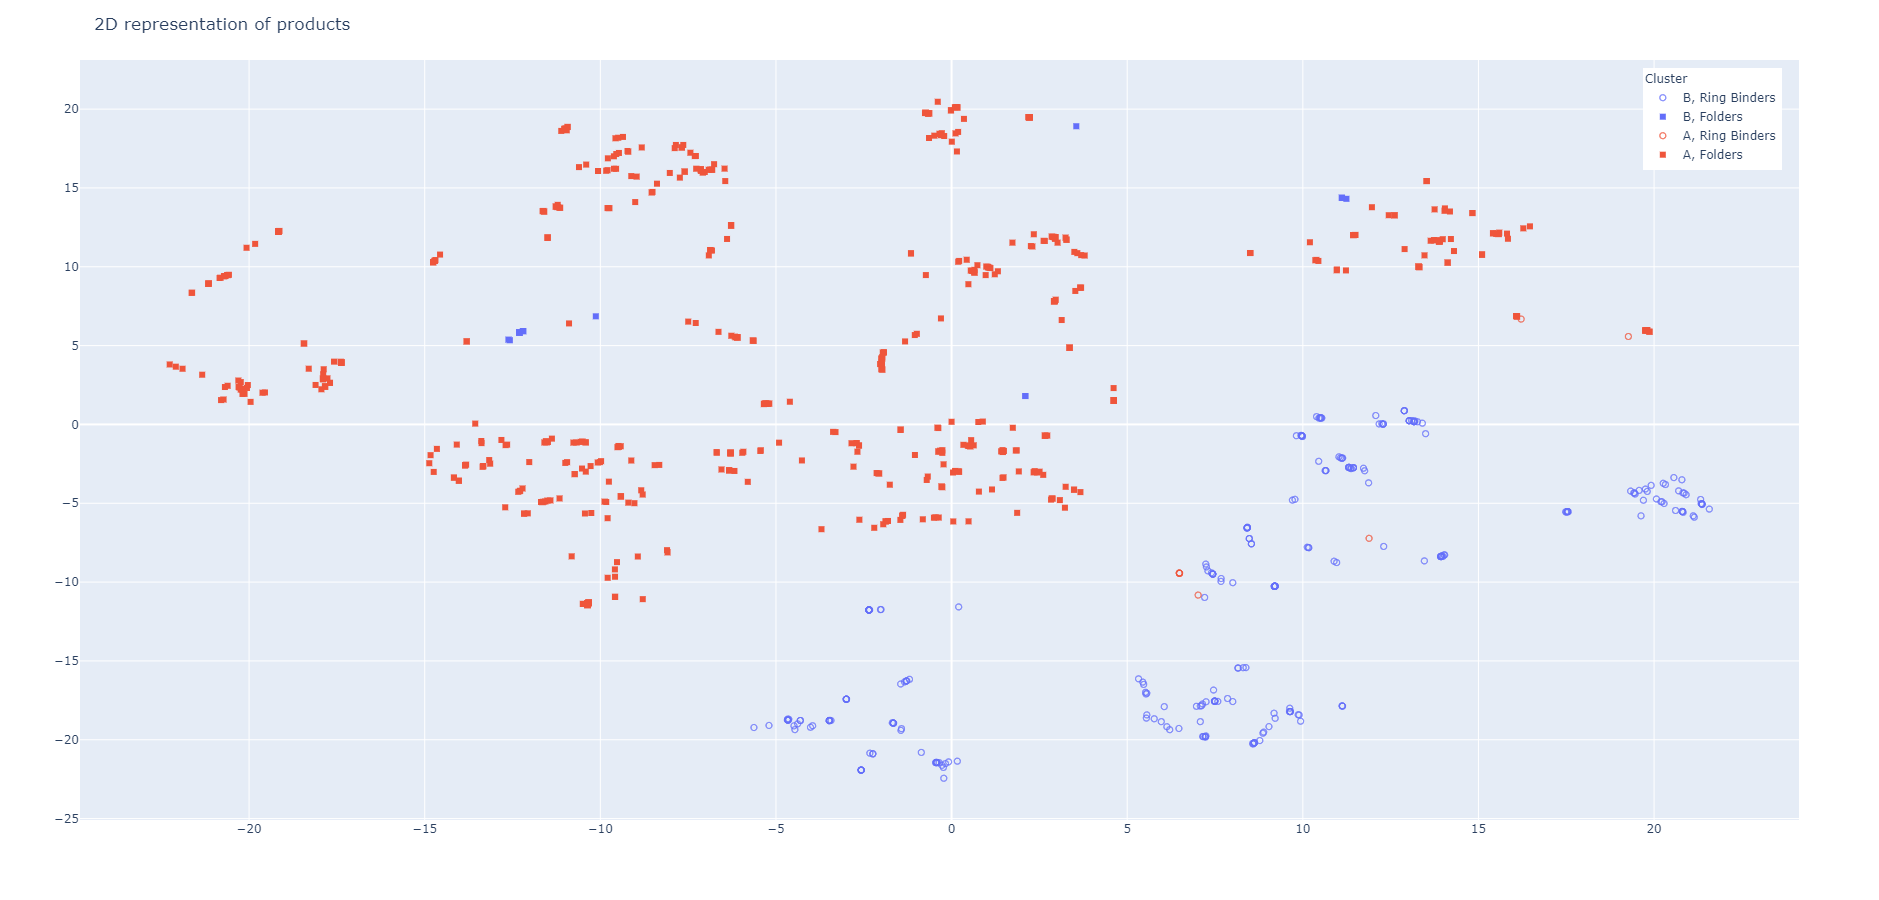

In [15]:
df_plot_data = df_cleaned_data.sort_values('cluster')

fig = px.scatter(
    df_plot_data,
    x="tsne_dim1",
    y="tsne_dim2",
    color="new_label",
    symbol = df_plot_data['category_name'],
    symbol_sequence= ['circle-open', 'square'],
    hover_name="title",
    hover_data={
        "category_name": False, "tsne_dim1": False, "tsne_dim2": False,
        "Category": df_plot_data['category_name'],
        "Supplier": df_plot_data['supplier_name'],
        "Format": True,
        "Weight": True,
        "Orientation": True,
    },
)
fig.update_layout(
    legend=dict(
        title="Cluster",
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    ),
    title='2D representation of products',
    autosize=False,
    width=1200,
    height=900,
)
fig.update_xaxes(showticklabels=True, title="")
fig.update_yaxes(showticklabels=True, title="")
fig.show()

In [16]:
extra_cols = [
    'category_name',
    'cluster',
    'new_label',
    'title',
    'supplier_name'
]

In [17]:
from itertools import chain
trainable_variables = list(sorted(chain.from_iterable(features_by_type.values())))

In [18]:
df_cleaned_data[extra_cols + trainable_variables].to_excel('../data/clustering-results.xlsx')